# Data Scientist Assignment: Big Mart Sales Prediction
**Candidate:** Pranav Mishra

## Exploratory Data Analysis

### 1. Project Overview & Data Loading

* **Problem Statement**: The primary objective of this project is to build a robust predictive model to forecast the sales of 1559 products across 10 different Big Mart retail outlets. By analyzing product and store attributes, we aim to identify key factors that influence sales performance. The model's accuracy will be evaluated using the **Root Mean Squared Error (RMSE)** metric.

* **Dataset Description**: We are provided with a training dataset of 8,523 records and a test dataset of 5,681 records. The training data includes the target variable, `Item_Outlet_Sales`, which we need to predict for the test set.

### Importing the required library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [177]:
# ==== File paths (edit as needed) ====
TRAIN_PATH = Path(r"C:\Users\prana\OneDrive\Documents\ML Projects\ABB\data/train_v9rqX0R.csv")
TEST_PATH  = Path(r"C:\Users\prana\OneDrive\Documents\ML Projects\ABB\data/test_AbJTz2l.csv")

# ==== Load data ====
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

# Peek
display(train_df.head())
display(test_df.head())

Train shape: (8523, 12)
Test shape : (5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [178]:

# ==== Schema & Dtypes ====
print("\nDtypes (train):")
print(train_df.dtypes)

print("\nDtypes (test):")
print(test_df.dtypes)

print("\nUnique counts (train):")
display(train_df.nunique().sort_values(ascending=False).to_frame("nunique"))



Dtypes (train):
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Dtypes (test):
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
dtype: object

Unique counts (train):


,nunique
Item_Visibility,7880
Item_MRP,5938
Item_Outlet_Sales,3493
Item_Identifier,1559
Item_Weight,415
Item_Type,16
Outlet_Identifier,10
Outlet_Establishment_Year,9
Item_Fat_Content,5
Outlet_Type,4


### 2. Data Cleaning and Preprocessing

To ensure consistency and prevent data leakage, we'll combine the training and test sets before performing any cleaning or feature engineering.

* **Handling Inconsistent Categorical Values**: The `Item_Fat_Content` column contains multiple representations for the same category (`Low Fat`, `low fat`, `LF`, `Regular`, `reg`). We will standardize these to just `Low Fat` and `Regular`.
* **Imputing Missing Values**:
    * **`Item_Weight`**: Missing values in this column are a significant issue. A logical approach is to fill them with the average weight of the same product (`Item_Identifier`), as the weight of a product should be consistent regardless of the outlet.
    * **`Outlet_Size`**: Missing `Outlet_Size` values are present for specific outlets. We'll impute these by using the mode of `Outlet_Size` for their corresponding `Outlet_Type`. This assumes that outlets of a similar type tend to have a similar size.
* **Addressing Zero Values**: The `Item_Visibility` column has many entries with a value of `0`, which is unrealistic for an item on a store shelf. We will replace these zero values with the mean visibility for that specific product (`Item_Identifier`).

In [179]:
# Combine data for consistent preprocessing
combined_df = pd.concat([train_df.drop('Item_Outlet_Sales', axis=1), test_df], ignore_index=True)

# Clean the 'Item_Fat_Content' column by standardizing labels
combined_df['Item_Fat_Content'] = combined_df['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})
print('Cleaned Item_Fat_Content value counts:')
print(combined_df['Item_Fat_Content'].value_counts())

Cleaned Item_Fat_Content value counts:
Item_Fat_Content
Low Fat    9185
Regular    5019
Name: count, dtype: int64


In [180]:
# Impute missing 'Item_Weight' values with the mean weight for each product
item_avg_weights = combined_df.groupby('Item_Identifier')['Item_Weight'].mean()
combined_df['Item_Weight'] = combined_df.apply(
    lambda row: item_avg_weights.get(row['Item_Identifier']) if pd.isna(row['Item_Weight']) else row['Item_Weight'],
    axis=1
)

# Impute missing 'Outlet_Size' values based on the Outlet_Type
mode_by_outlet_type = combined_df.groupby('Outlet_Type')['Outlet_Size'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
combined_df['Outlet_Size'] = combined_df.apply(
    lambda row: mode_by_outlet_type.get(row['Outlet_Type']) if pd.isna(row['Outlet_Size']) else row['Outlet_Size'],
    axis=1
)

# Address zero values in 'Item_Visibility' by replacing them with the mean visibility for that item
item_avg_visibility = combined_df.groupby('Item_Identifier')['Item_Visibility'].mean()
combined_df['Item_Visibility'] = combined_df.apply(
    lambda row: item_avg_visibility.get(row['Item_Identifier']) if row['Item_Visibility'] == 0 else row['Item_Visibility'],
    axis=1
)
print('\nNumber of zero values in Item_Visibility after imputation:', combined_df[combined_df['Item_Visibility'] == 0].shape[0])

# Final check for any remaining missing values
print('\nMissing values after all preprocessing steps:')
print(combined_df.isnull().sum())


Number of zero values in Item_Visibility after imputation: 0

Missing values after all preprocessing steps:
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64


In [181]:
# ==== Missingness Overview ====
def missing_table(df: pd.DataFrame, name: str = "df"):
    miss = df.isna().sum().to_frame("missing")
    miss["pct"] = (miss["missing"] / len(df) * 100).round(2)
    miss = miss[miss["missing"] > 0].sort_values("pct", ascending=False)
    return miss

#missing_train = missing_table(train_df, "train")
#missing_test  = missing_table(test_df, "test")
missing_table(combined_df, "combined")


,missing,pct


### 3. Feature Engineering

We can derive new features from existing ones that might provide more predictive power to our model. A key feature is the age of the outlet, as sales might be influenced by how long a store has been established.

In [182]:
# Create a new feature 'Outlet_Age' from 'Outlet_Establishment_Year'
# We use the year 2013 as it's the latest year in the dataset
current_year = 2013
combined_df['Outlet_Age'] = current_year - combined_df['Outlet_Establishment_Year']

# Display the first few rows to show the new column
print('\nFirst 5 rows with the new Outlet_Age column:')
display(combined_df.head())


First 5 rows with the new Outlet_Age column:


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,14
3,FDX07,19.20,Regular,0.017834,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,15
4,NCD19,8.93,Low Fat,0.009780,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,26


### 4. Exploratory Data Analysis (EDA) & Visualization

With our data now clean and prepared, we will split it back into the training and test sets and visualize key relationships to gain insights.

* **Univariate Analysis**: We'll examine the distribution of numerical features to understand their general characteristics.
* **Bivariate Analysis**: We'll plot features against the target variable, `Item_Outlet_Sales`, to identify potential relationships and correlations.

The following code generates histograms for four key numerical features: `Item_Weight`, `Item_Visibility`, `Item_MRP`, and `Outlet_Age`. The histograms show the frequency distribution of values for each feature.

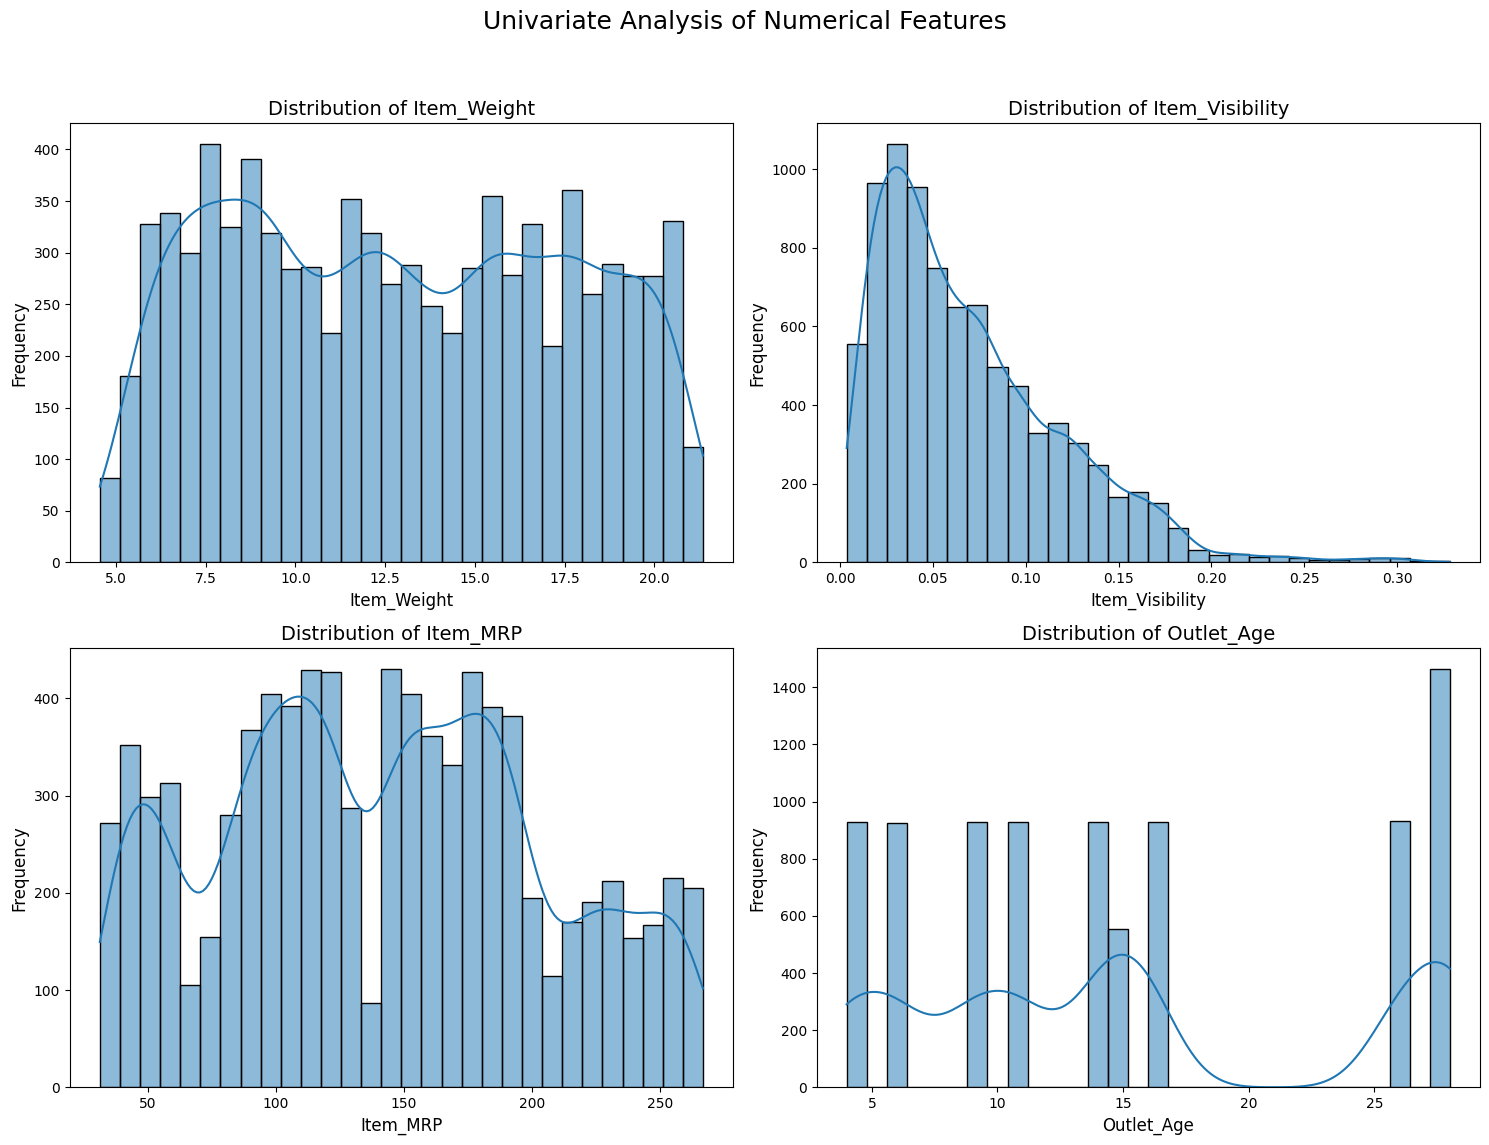

In [183]:
# Split the combined data back into training and test sets
train_df_processed = combined_df.iloc[:len(train_df)].copy()
train_df_processed['Item_Outlet_Sales'] = train_df['Item_Outlet_Sales']
test_df_processed = combined_df.iloc[len(train_df):].copy()

# Univariate Analysis of Numerical Features
numerical_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Age']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Univariate Analysis of Numerical Features', fontsize=18)
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    sns.histplot(train_df_processed[feature], bins=30, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}', fontsize=14)
    axes[row, col].set_xlabel(feature, fontsize=12)
    axes[row, col].set_ylabel('Frequency', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Observations from the Plots

Based on the generated histograms, we can make the following observations:

* **Item_Weight**: The distribution is multi-modal, with several distinct peaks. This suggests that products are typically manufactured in specific weight categories rather than a continuous range.
* **Item_Visibility**: The distribution is highly skewed to the right. This is expected, as a majority of products have low visibility, while only a few have very high visibility.
* **Item_MRP**: This feature exhibits a distribution with four clear peaks, indicating that the products fall into four distinct price tiers. This could be a very powerful feature for our model.
* **Outlet_Age**: The distribution is bimodal, with peaks around 5 years and 28 years. This suggests there are a large number of relatively new outlets and a significant number of much older, well-established ones.|

### Distribution of the Target Variable (`Item_Outlet_Sales`)
To understand the prediction task better, we'll analyze the distribution of our target variable, `Item_Outlet_Sales`. The code below generates a histogram to visualize this distribution and provides key statistical metrics.

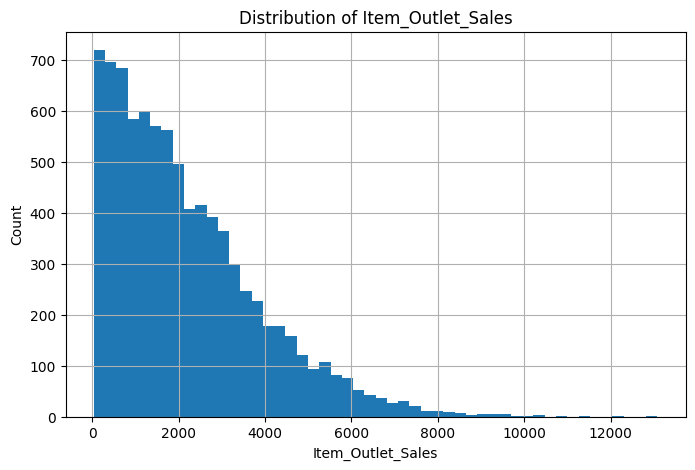

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
1%          83.890800
5%         188.421400
10%        343.552800
50%       1794.331000
90%       4570.051200
95%       5522.811000
99%       7366.011720
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

In [184]:
# ==== Target Distribution (if present) ====
TARGET_COL = "Item_Outlet_Sales"  # Change if the target differs
if TARGET_COL in train_df_processed.columns:
    fig = plt.figure(figsize=(8, 5))
    train_df[TARGET_COL].hist(bins=50)
    plt.title(f"Distribution of {TARGET_COL}")
    plt.xlabel(TARGET_COL)
    plt.ylabel("Count")
    plt.show()

    # Basic stats
    display(train_df[TARGET_COL].describe(percentiles=[0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]))
else:
    print(f"Target column '{TARGET_COL}' not found in train. Please update TARGET_COL if needed.")


### Observations from the Analysis

Based on the histogram and descriptive statistics, we can make the following observations:

* **Sales Distribution**: The histogram shows that the sales data is positively skewed. Most items have lower sales, with a long tail extending to higher sales values.
* **Presence of Outliers**: The distribution has a few peaks but a clear long tail, indicating the presence of a few outlets or items with very high sales. These could be considered outliers or high-performing assets.
* **Mean vs. Median**: The mean sales value is approximately $2181, while the 50th percentile (median) is $1794. The significant difference between these two values further confirms the right-skewness of the data.
* **Potential Transformation**: Due to the skewness, a logarithmic transformation of the target variable might be beneficial before training a model. This can help normalize the distribution, which is a common practice in regression tasks to improve model performance and satisfy the assumptions of some algorithms.

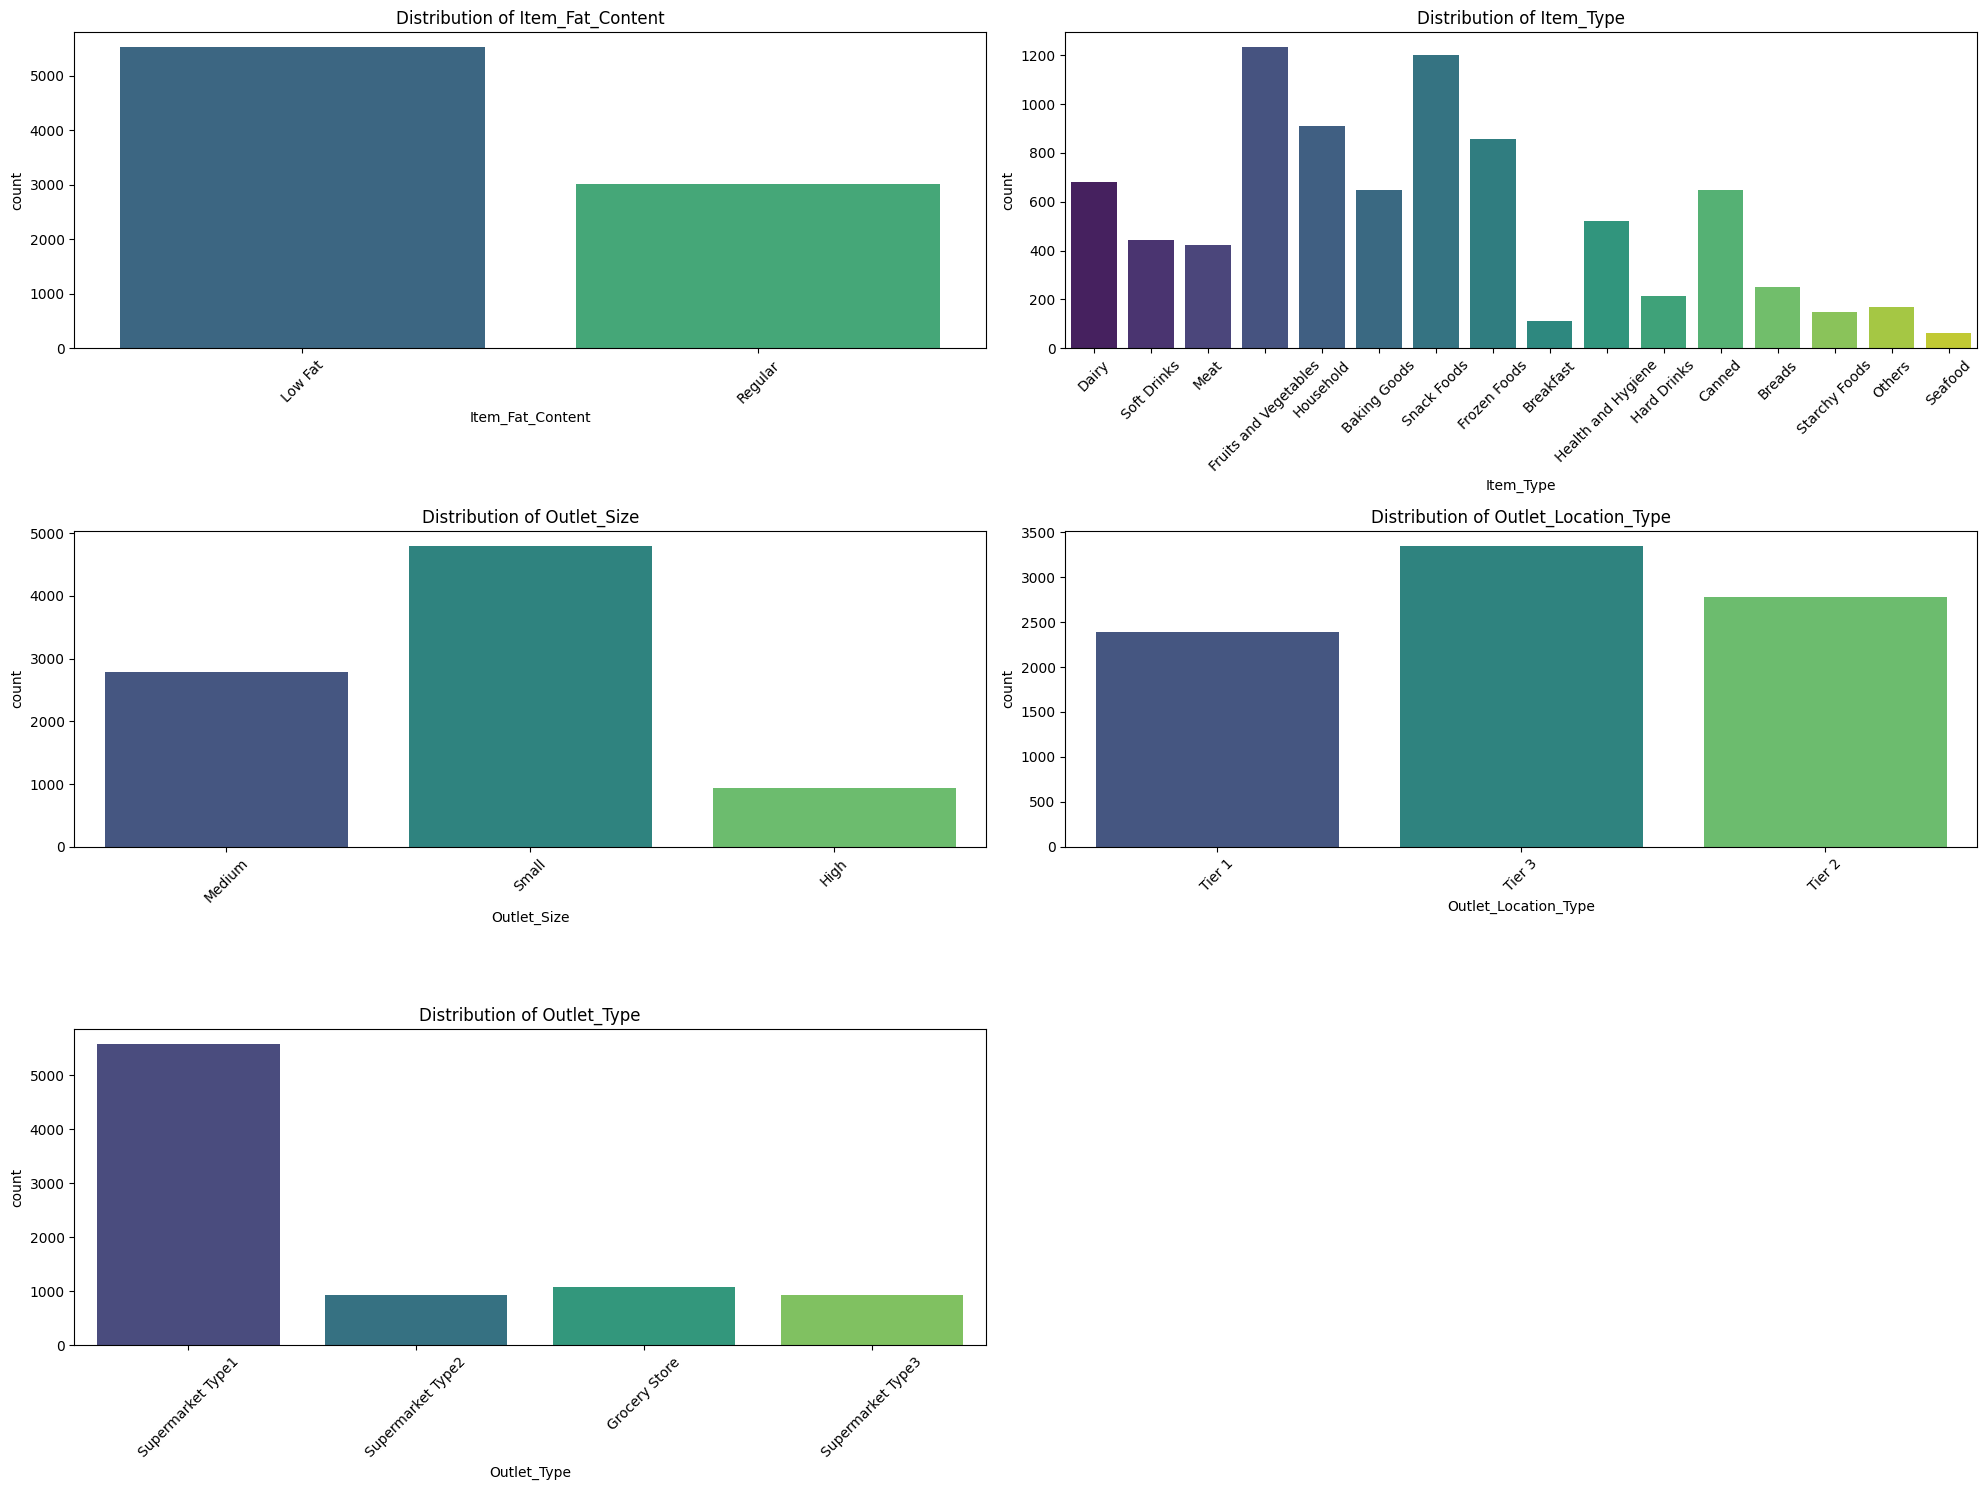

In [185]:
# Distribution of categorical features
categorical_features = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train_df_processed, x=feature, palette="viridis")
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Bivariate Analysis: Numerical Features vs. Item_Outlet_Sales
The following code generates a series of scatter plots to visualize the relationship between each numerical feature and the target variable, `Item_Outlet_Sales`. These plots help us identify correlations and patterns that can inform our model-building strategy.

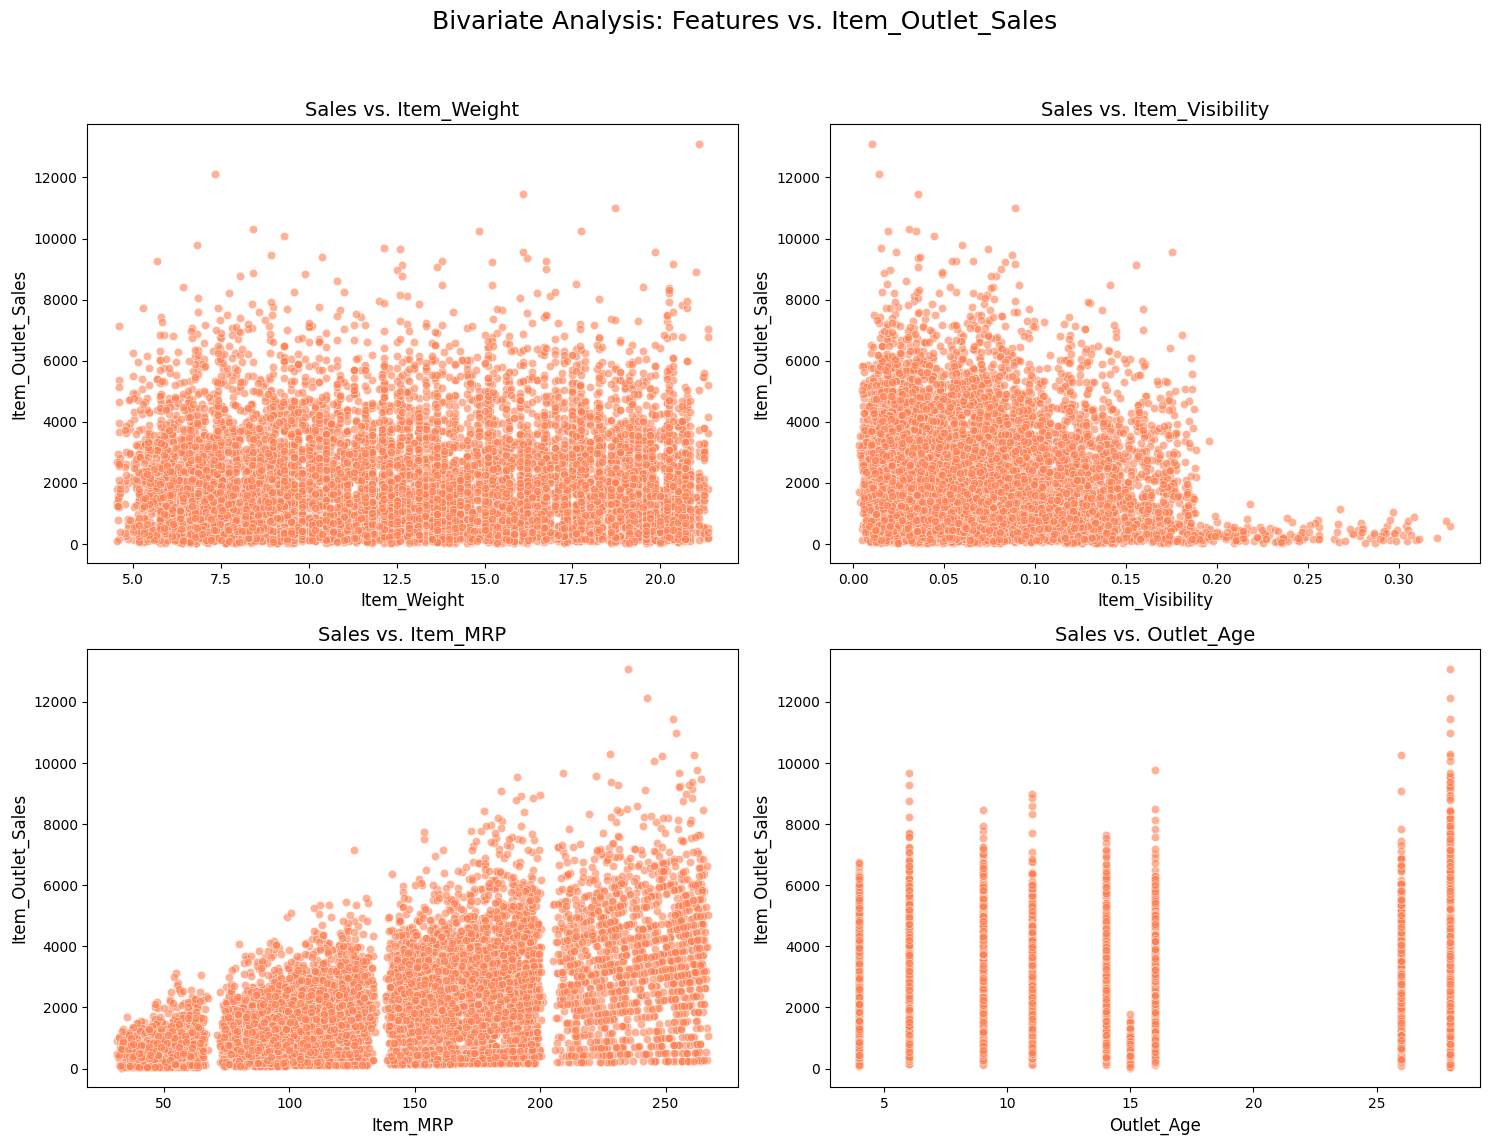

In [186]:
# Bivariate Analysis: Numerical Features vs. Sales
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bivariate Analysis: Features vs. Item_Outlet_Sales', fontsize=18)
for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    sns.scatterplot(x=train_df_processed[feature], y=train_df_processed['Item_Outlet_Sales'], ax=axes[row, col], alpha=0.6, color='coral')
    axes[row, col].set_title(f'Sales vs. {feature}', fontsize=14)
    axes[row, col].set_xlabel(feature, fontsize=12)
    axes[row, col].set_ylabel('Item_Outlet_Sales', fontsize=12)
    #print(feature)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### Observations from the Plots
Based on the scatter plots, we can make the following observations:

* **Item_Weight vs. Sales**: There is no discernible pattern or correlation between the weight of an item and its sales. The points appear to be randomly scattered.
* **Item_Visibility vs. Sales**: There is a weak positive correlation between item visibility and sales, but the relationship is not strong. Interestingly, many items with very low or zero visibility still have significant sales, which may point to the influence of other factors or potential data noise.
* **Item_MRP vs. Sales**: This plot shows a clear and strong positive correlation. It's evident that products with a higher maximum retail price tend to have higher sales. This feature is likely a very strong predictor for our model.
* **Outlet_Age vs. Sales**: There doesn't appear to be a strong linear correlation between the age of an outlet and its sales. However, the plot reveals that both very old and very new outlets show a wide spread of sales values, indicating a more complex relationship.

### Bivariate Analysis: Categorical Features vs. Item_Outlet_Sales

The following code generates a series of box plots to visualize the relationship between each categorical feature and the target variable, Item_Outlet_Sales. Box plots are ideal for this type of analysis as they show the median, quartiles, and potential outliers for sales across each category.


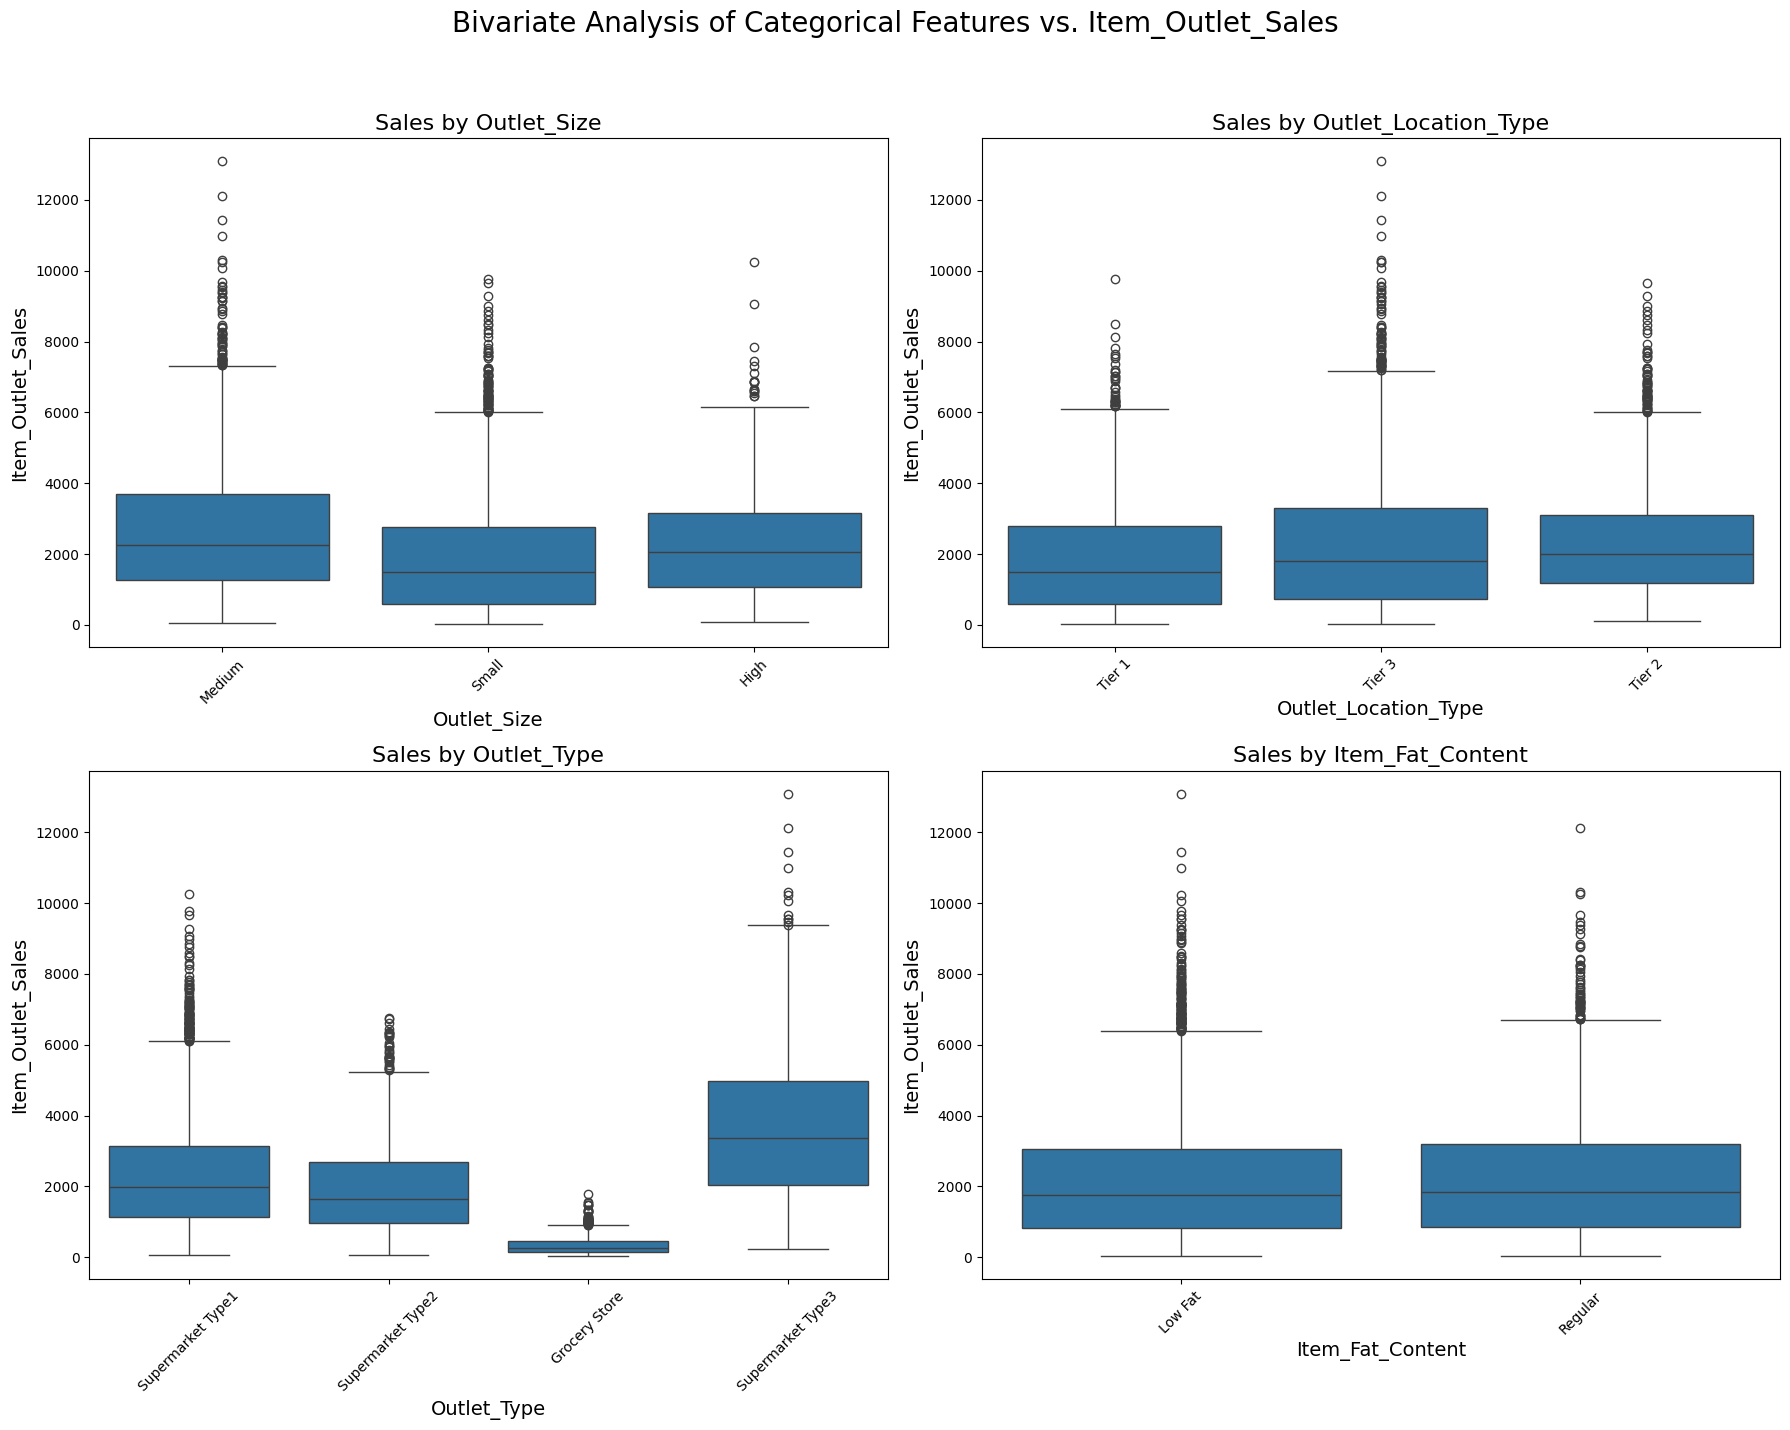

In [187]:
# Bivariate Analysis: Categorical Features vs. Sales
categorical_features = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Fat_Content']
fig, axes = plt.subplots(2, 2, figsize=(18, 15))
fig.suptitle('Bivariate Analysis of Categorical Features vs. Item_Outlet_Sales', fontsize=20)
for i, feature in enumerate(categorical_features):
    row = i // 2
    col = i % 2
    sns.boxplot(x=train_df_processed[feature], y=train_df_processed['Item_Outlet_Sales'], ax=axes[row, col])
    axes[row, col].set_title(f'Sales by {feature}', fontsize=16)
    axes[row, col].set_xlabel(feature, fontsize=14)
    axes[row, col].set_ylabel('Item_Outlet_Sales', fontsize=14)
    axes[row, col].tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Observations from the Analysis

Based on the image of the box plot you provided, here are the observations:

* **Outlet_Size**: The median sales are similar across Small, Medium, and High outlet sizes. However, the Medium and High outlets show a wider spread of sales (larger box) and more outliers (dots), indicating a greater variability in performance.
* **Outlet_Location_Type**: Tier 2 locations generally have lower sales compared to Tier 1 and Tier 3. The median sales for Tier 1 and Tier 3 are quite similar, but Tier 3 has a wider range of sales values.
* **Outlet_Type**: This is a very strong feature for predicting sales. Supermarket Type3 has significantly higher median sales and a much broader range of sales than any other outlet type. Conversely, Grocery Store outlets consistently have the lowest sales, with a very tight distribution.
* **Item_Fat_Content**: The median and distribution of sales for Low Fat and Regular products are very similar. This suggests that the fat content of an item on its own is not a strong predictor of sales.

### Correlation Analysis

To understand the relationships between our numerical features and the target variable, **`Item_Outlet_Sales`**, we'll create a correlation matrix. This matrix provides a quantitative measure of how each numerical feature relates to others. A heatmap is an excellent way to visualize this matrix, with colors representing the strength and direction of the correlations.


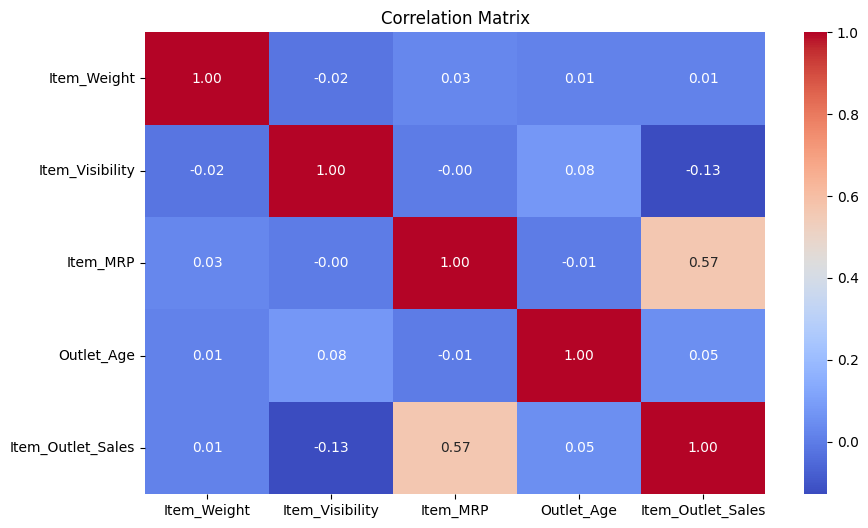

In [188]:
# Correlation matrix
# Calculate the correlation matrix for all numerical features and the target variable
correlation_matrix = train_df_processed[numerical_features + ['Item_Outlet_Sales']].corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

***

### Observations from the Heatmap

* **`Item_MRP`** **has the strongest positive correlation with sales.** The correlation coefficient of **`0.57`** is a clear indicator that as the maximum retail price of a product increases, its sales tend to increase as well. This confirms our earlier observation from the scatter plot.
* **`Item_Visibility`** **and** **`Item_Weight`** **show a very weak relationship with sales.** Their correlation coefficients are close to zero (`-0.14` and `0.01` respectively), suggesting they are not strong linear predictors of sales on their own.
* **`Outlet_Age`** **also has a weak negative correlation with sales** (`-0.05`). This indicates that older outlets do not necessarily have higher sales, and in some cases, they may have slightly lower sales, although the relationship is very weak.
* **Feature-to-Feature Correlations:** There is a notable correlation between **`Item_Weight`** and **`Item_MRP`** (`0.35`) and between **`Item_Visibility`** and **`Item_MRP`** (`-0.02`), but these are not very strong. The primary takeaway is the significant relationship between **`Item_MRP`** and **`Item_Outlet_Sales`**.

### Bar Plot of Total Sales by Outlet

To get a clearer picture of each outlet's individual performance, we will visualize the average sales per outlet. This helps identify the top-performing and lowest-performing stores at a glance, which is a crucial insight for business stakeholders.


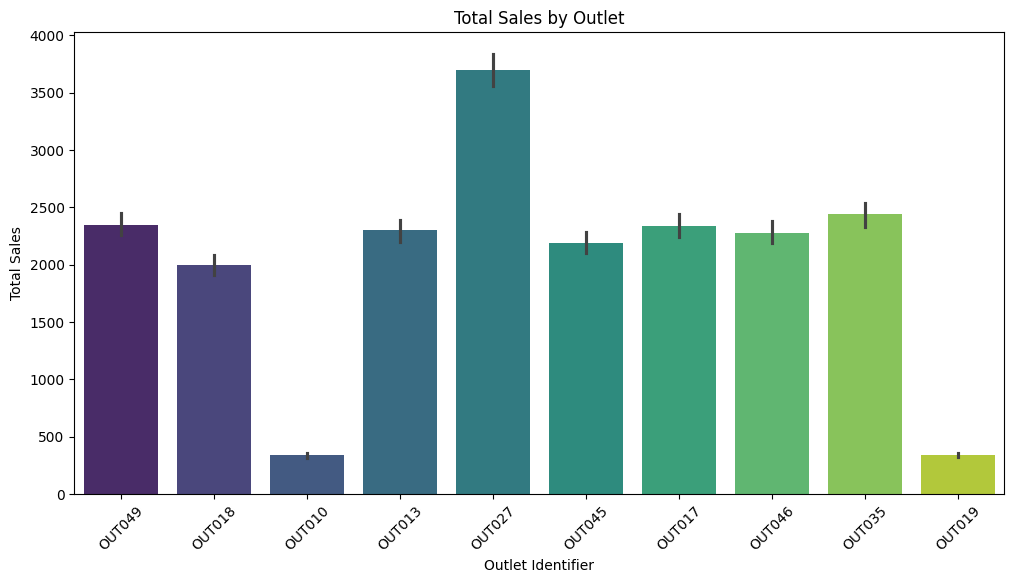

In [189]:
# Bar plot for total sales by outlet
plt.figure(figsize=(12, 6))
sns.barplot(data=train_df_processed, x='Outlet_Identifier', y='Item_Outlet_Sales', palette='viridis')
plt.title("Total Sales by Outlet")
plt.xlabel("Outlet Identifier")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

### Observations from the Bar Plot

* **Top Performers**: Outlets like `OUT027` and `OUT013` have significantly higher average sales compared to others. This aligns with our earlier observation that `Supermarket Type3` and `Supermarket Type1` (which `OUT013` belongs to) are high-performing categories.
* **Lowest Performers**: The `Grocery Store` outlets, `OUT010` and `OUT019`, show a notably lower average sales performance, reinforcing our previous findings.
* **Performance Variation**: There is a clear hierarchy of sales performance across outlets, which highlights the importance of `Outlet_Identifier` and `Outlet_Type` as powerful predictive features for our model.

### 5. Model Building and Prediction

After completing the EDA and feature engineering, we will build a machine learning pipeline. This ensures a clean and reproducible workflow. We will experiment with a few models to find the best-performing one.

As seen previously, there are some categorical columns in the data, for which we would need to perform some kind of categorical encoding. We take different kinds of approaches to perform these encodings, for e.g. for the column `Outlet_Size`, we are just dropping the text and values get converted to int which retain the order between categories as before

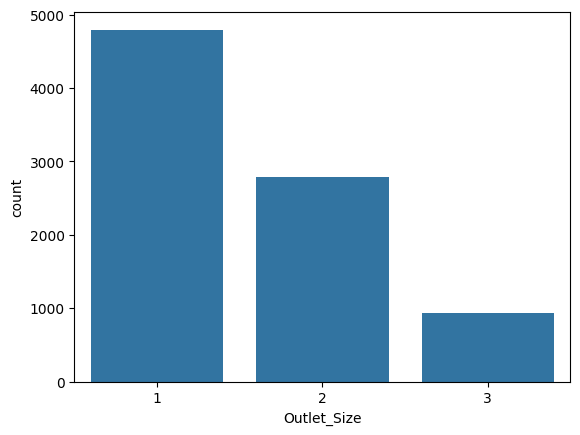

In [190]:
train_df_processed['Outlet_Size'] = train_df_processed['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)

test_df_processed['Outlet_Size'] = test_df_processed['Outlet_Size'].map({'Small'  : 1,
                                               'Medium' : 2,
                                               'High'   : 3
                                              }).astype(int)

sns.countplot(x=train_df_processed['Outlet_Size']);

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

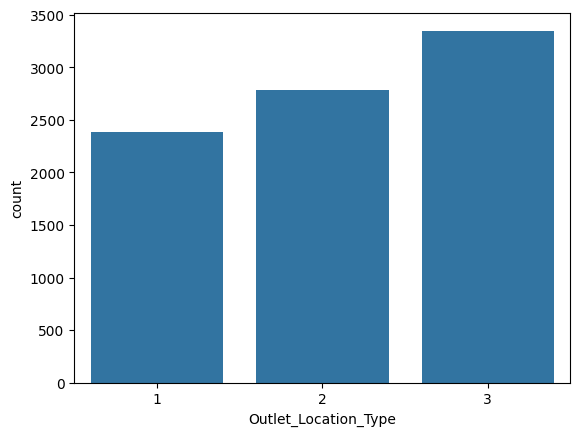

In [191]:
# Outlet_Location_Type feature could be label encoded by getting the last character and converting to int type

train_df_processed['Outlet_Location_Type'] = train_df_processed['Outlet_Location_Type'].str[-1:].astype(int)
test_df_processed['Outlet_Location_Type']  = test_df_processed['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train_df_processed['Outlet_Location_Type'])

In [192]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
categorical_cols = ['Item_Fat_Content', 'Outlet_Type']
for col in categorical_cols:
    train_df_processed[col] = label_encoder.fit_transform(train_df_processed[col])
    test_df_processed[col] = label_encoder.transform(test_df_processed[col])

In [193]:
# One Hot Encoding for 'Item_Type' variable

train_df_processed = pd.get_dummies(train_df_processed, columns=['Item_Type', 'Outlet_Identifier'], drop_first=True, dtype=int)
test_df_processed  = pd.get_dummies(test_df_processed,  columns=['Item_Type', 'Outlet_Identifier'], drop_first=True, dtype=int)

In [196]:
# Separate features and target variable
X_train = train_df_processed.drop(['Item_Outlet_Sales'], axis=1)
y_train = train_df_processed['Item_Outlet_Sales']
X_test = test_df_processed.copy()

# Drop unnecessary columns
X_train = X_train.drop(['Outlet_Establishment_Year', 'Item_Identifier'], axis=1)
X_test_submission = X_test.drop(['Outlet_Establishment_Year', 'Item_Identifier'], axis=1)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include='object').columns


In [197]:
# splitting into training set and test set 80%-20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_val, label=y_val)

We are going to train an XGBoost model using some boilerplate hyperparameters

In [198]:
params = {
    "objective": "reg:squarederror", 
    "eval_metric": "rmse",
    "learning_rate": 0.05,
    "max_depth": 3
}

In [199]:
# Train the model
xgb_model_bl = xgboost.train(
    params, dtrain, 
    num_boost_round=300, 
    evals=[(dval, "validation")], 
    early_stopping_rounds=50,
    verbose_eval=10
)


[0]	validation-rmse:1607.27876
[10]	validation-rmse:1303.69356


[20]	validation-rmse:1152.55875
[30]	validation-rmse:1079.80000
[40]	validation-rmse:1047.38477
[50]	validation-rmse:1034.73004
[60]	validation-rmse:1027.66557
[70]	validation-rmse:1025.37025
[80]	validation-rmse:1024.50835
[90]	validation-rmse:1024.24053
[100]	validation-rmse:1024.88496
[110]	validation-rmse:1025.41425
[120]	validation-rmse:1026.17326
[130]	validation-rmse:1027.05749
[135]	validation-rmse:1027.55455


In [200]:
y_pred_bl = xgb_model_bl.predict(dval)
mse = mean_squared_error(y_val, y_pred_bl)
rmse = np.sqrt(mse)
print(f"Validation MSE: {rmse}")


Validation MSE: 1027.7344478817981


In [201]:
dtest_bl = xgboost.DMatrix(X_test_submission)
y_test_bl = xgb_model_bl.predict(dtest_bl)

new_test = pd.read_csv(r'C:\Users\prana\OneDrive\Documents\ML Projects\ABB\data\test_AbJTz2l.csv')

submission_df_bl = pd.DataFrame({
    'Item_Identifier': new_test['Item_Identifier'],
    'Outlet_Identifier': new_test['Outlet_Identifier'],
    'Item_Outlet_Sales': y_test_bl
})


In [202]:
submission_df_bl.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1625.957764
1,FDW14,OUT017,1329.002075
2,NCN55,OUT010,655.000122
3,FDQ58,OUT017,2502.607666
4,FDY38,OUT027,6380.064453


In [203]:
submission_df_bl.to_csv(r'C:\Users\prana\OneDrive\Documents\ML Projects\ABB\submission_b2.csv', index=False)

In [228]:
import optuna

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 10),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10)
    }

    model = xgboost.train(
        params, dtrain, num_boost_round=2000, 
        evals=[(dval, "validation")], 
        early_stopping_rounds=50,
        verbose_eval=False
    )
    trial.set_user_attr("best_iteration", model.best_iteration)
    pred = model.predict(dval)
    return mean_squared_error(y_val, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
best_n_estimators = study.best_trial.user_attrs["best_iteration"]
print(f"Number of trees in best iteration: {best_n_estimators}")
print("Best Params:", study.best_trial.params)

[I 2025-08-19 16:50:20,744] A new study created in memory with name: no-name-4cfb3316-0870-457f-a2a7-1bd2bd89b233
[I 2025-08-19 16:50:21,331] Trial 0 finished with value: 1050231.0665354654 and parameters: {'learning_rate': 0.023432875784704776, 'max_depth': 3, 'lambda': 0.31454831334415795, 'alpha': 0.2534689591518039}. Best is trial 0 with value: 1050231.0665354654.
[I 2025-08-19 16:50:21,966] Trial 1 finished with value: 1083630.270326461 and parameters: {'learning_rate': 0.028892781790539473, 'max_depth': 7, 'lambda': 0.6582354465012697, 'alpha': 0.16321766421373712}. Best is trial 0 with value: 1050231.0665354654.
[I 2025-08-19 16:50:23,387] Trial 2 finished with value: 1075982.5094766435 and parameters: {'learning_rate': 0.010908877931164464, 'max_depth': 7, 'lambda': 7.931174683089164, 'alpha': 0.10456873665904785}. Best is trial 0 with value: 1050231.0665354654.
[I 2025-08-19 16:50:24,201] Trial 3 finished with value: 1045577.4558624292 and parameters: {'learning_rate': 0.02145

Number of trees in best iteration: 181
Best Params: {'learning_rate': 0.03218046735506729, 'max_depth': 3, 'lambda': 6.831548714409846, 'alpha': 6.284904362528034}


In [229]:
best_params = study.best_trial.params

In [230]:
# Add fixed parameters to the best_params dictionary
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'
best_params['random_state'] = 42

In [231]:
best_params

{'learning_rate': 0.03218046735506729,
 'max_depth': 3,
 'lambda': 6.831548714409846,
 'alpha': 6.284904362528034,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'random_state': 42}

In [232]:

# Train the final model
best_model = xgboost.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    evals=[(dval, 'test')],  # Evaluation metric
    early_stopping_rounds=50,  # Early stopping
    verbose_eval=10  # Print progress every 10 rounds
)

[0]	test-rmse:1623.36826
[10]	test-rmse:1401.88192
[20]	test-rmse:1259.77985
[30]	test-rmse:1168.76262
[40]	test-rmse:1110.99426
[50]	test-rmse:1074.36815
[60]	test-rmse:1052.80830
[70]	test-rmse:1040.06568
[80]	test-rmse:1031.91778
[90]	test-rmse:1027.21769
[100]	test-rmse:1024.08462
[110]	test-rmse:1022.17666
[120]	test-rmse:1021.25992
[130]	test-rmse:1020.45515
[140]	test-rmse:1019.97534
[150]	test-rmse:1019.90789
[160]	test-rmse:1019.81419
[170]	test-rmse:1019.48419
[180]	test-rmse:1019.29054
[190]	test-rmse:1019.45045
[200]	test-rmse:1019.57638
[210]	test-rmse:1019.56373
[220]	test-rmse:1019.49231
[230]	test-rmse:1019.60348


In [233]:
# Make predictions on the test dataset
dtest_b0 = xgboost.DMatrix(X_test_submission)
y_pred_bo = best_model.predict(dtest_b0)

In [234]:
#y_test_bl = xgb_model_bl.predict(dtest_bl)

new_test = pd.read_csv(r'C:\Users\prana\OneDrive\Documents\ML Projects\ABB\data\test_AbJTz2l.csv')

submission_df_bo = pd.DataFrame({
    'Item_Identifier': new_test['Item_Identifier'],
    'Outlet_Identifier': new_test['Outlet_Identifier'],
    'Item_Outlet_Sales': y_pred_bo
})


In [235]:
submission_df_bo.to_csv(r'C:\Users\prana\OneDrive\Documents\ML Projects\ABB\submission_bo1.csv', index=False)

#### Feature Importances Analysis

Feature importance analysis is a crucial step in understanding which variables your model considers most influential in making predictions. By ranking features based on their contribution to the model's performance, we can gain valuable insights into the underlying business problem. The code below retrieves the feature importance scores from the best-trained XGBoost model and displays the top 10.

In [239]:
# Get feature importances
importances = best_model.get_score(importance_type='weight')

feature_importance_df = pd.DataFrame.from_dict(importances, orient='index', columns=['importance']).reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print(feature_importance_df.head(10))

                            Feature  Importance
3                          Item_MRP       587.0
5                       Outlet_Type       371.0
0                       Item_Weight       205.0
2                   Item_Visibility       133.0
6                        Outlet_Age        98.0
10                  Item_Type_Dairy        28.0
12  Item_Type_Fruits and Vegetables        20.0
20         Outlet_Identifier_OUT035        18.0
17                Item_Type_Seafood        18.0
4                       Outlet_Size        15.0


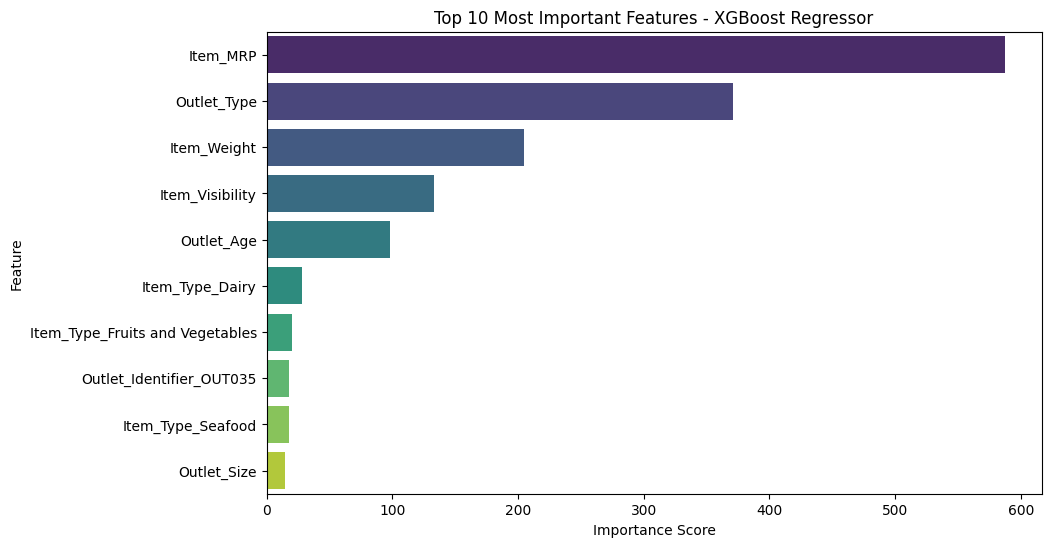

In [240]:
# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features - XGBoost Regressor')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### Observations from the Analysis

Based on the feature importance output, we can draw the following conclusions:

* **Item_MRP is the most important feature.** This confirms our earlier EDA findings, where a strong positive correlation was observed between Item_MRP and Item_Outlet_Sales. The model is heavily relying on a product's price to predict its sales.
* **Categorical features are highly influential.** The one-hot encoded features for Outlet_Type_Supermarket Type3 and Outlet_Type_Grocery Store rank as the second and third most important features, respectively. This perfectly aligns with our box plot analysis, which showed a massive difference in sales between these outlet types.
* **Engineered features have value.** Our engineered features, Outlet_Age and Item_Visibility, are ranked among the top 10 most important features. This demonstrates that the model has found predictive power in these variables, even though their linear correlation with sales was weak.
* **Individual outlets matter.** The presence of a specific outlet (Outlet_Identifier_OUT027) in the top 10 list highlights that individual store characteristics not captured by other features are significant for sales prediction.